# Outfit Compatibility Prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from collections import Counter
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
import pickle

import sys
sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
import effnetv2_model

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
# import wandb
# from wandb.keras import WandbCallback

# wandb.init(project="compatibility")

In [5]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
data_type = "nondisjoint" # "nondisjoint", "disjoint"
train_dir = os.path.join(base_dir, data_type)
image_dir = os.path.join(base_dir, "images")
embed_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/precomputed"
train_json = "train.json"
valid_json = "valid.json"
test_json = "test.json"

train_file = "compatibility_train.txt"
valid_file = "compatibility_valid.txt"
test_file = "compatibility_test.txt"
item_file = "polyvore_item_metadata.json"
outfit_file = "polyvore_outfit_titles.json"

model_type = "rnn" #"set-transformer"
include_text = True

In [6]:
with open(os.path.join(train_dir, train_json), 'r') as fr:
    train_pos = json.load(fr)
    
with open(os.path.join(train_dir, valid_json), 'r') as fr:
    valid_pos = json.load(fr)
    
with open(os.path.join(train_dir, test_json), 'r') as fr:
    test_pos = json.load(fr)
    
with open(os.path.join(base_dir, item_file), 'r') as fr:
    pv_items = json.load(fr)
    
with open(os.path.join(base_dir, outfit_file), 'r') as fr:
    pv_outfits = json.load(fr)
print(f"Total {len(train_pos)}, {len(valid_pos)}, {len(test_pos)} outfits in train, validation and test split, respectively")

Total 53306, 5000, 10000 outfits in train, validation and test split, respectively


In [7]:
min([len(o['items']) for o in train_pos]), min([len(o['items']) for o in valid_pos]), min([len(o['items']) for o in test_pos])

(2, 2, 2)

In [8]:
with open(os.path.join(train_dir, train_file), 'r') as fr:
    train_X, train_y = [], []
    for line in fr:
        elems = line.strip().split()
        train_y.append(elems[0])
        train_X.append(elems[1:])

with open(os.path.join(train_dir, valid_file), 'r') as fr:
    valid_X, valid_y = [], []
    for line in fr:
        elems = line.strip().split()
        valid_y.append(elems[0])
        valid_X.append(elems[1:])

with open(os.path.join(train_dir, test_file), 'r') as fr:
    test_X, test_y = [], []
    for line in fr:
        elems = line.strip().split()
        test_y.append(elems[0])
        test_X.append(elems[1:])

print(f"Total {len(train_X)}, {len(valid_X)}, {len(test_X)} examples in train, validation and test split, respectively")

Total 106612, 10000, 20000 examples in train, validation and test split, respectively


In [9]:
item_dict = {}
for ii, outfit in enumerate(train_pos):
    items = outfit['items']
    mapped = train_X[ii]
    item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
print(len(item_dict))

for ii, outfit in enumerate(valid_pos):
    items = outfit['items']
    mapped = valid_X[ii]
    item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
print(len(item_dict))

for ii, outfit in enumerate(test_pos):
    items = outfit['items']
    mapped = test_X[ii]
    item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
print(len(item_dict))

284767
311548
365054


In [10]:
from build_model import build_multilevel_transformer
from build_model import build_set_transformer
from rnn import build_multilevel_rnn_unequal, build_fc_model

In [18]:
model_type = "rnn" # "set-transformer", "rnn"
include_text = True
use_image_embedding = True # False # True
use_graphsage = False
batch_size = 32
max_seq_len = 8
if use_image_embedding:
    if use_graphsage:
        image_embedding_dim = 50
        image_embedding_file = os.path.join(embed_dir, "graphsage_dict2_polyvore.pkl")
    else:
        image_embedding_dim = 256 # 1280
#         image_embedding_file = os.path.join(embed_dir, "effnet_tuned_polyvore.pkl")
        image_embedding_file = os.path.join(embed_dir, "triplet_polyvore_image.pkl")
else:
    image_embedding_dim = (224, 224, 3)
    image_embedding_file = os.path.join(embed_dir, "effnet_tuned_polyvore.pkl") # not used
# text_embedding_file = os.path.join(embed_dir, "bert_polyvore.pkl")
text_embedding_file = os.path.join(embed_dir, "triplet_polyvore_text.pkl")
text_embedding_dim = 256 # 768

In [14]:
# from rnn import build_multilevel_rnn_unequal
if model_type == "fc":
    model = build_fc_model(max_seq_len, 
                           image_embedding_dim,
                         num_classes=2,
                         num_layers=2,
                         d_model=512,
                         rnn="bilstm",
                         final_activation="sigmoid",
                         include_text=include_text
                        )
elif model_type == "rnn":
    model = build_multilevel_rnn_unequal(max_seq_len, 
                                         image_embedding_dim,
                                         num_classes=2,
                                         num_layers=2,
                                         d_model=512,
                                         rnn="bilstm",
                                         final_activation="sigmoid",
                                         include_text=include_text,
                                         text_feature_dim=text_embedding_dim,
                                        )
elif model_type == "transformer":
    model = build_multilevel_transformer(max_seq_len, 
                                         image_embedding_dim,
                                         num_layers=1,
                                         d_model=64,
                                         num_heads=1,
                                         dff=32,
                                         rate=0.0,
                                         include_text=include_text,
                                         inp_dim2=768,
                                         num_classes=2,
                                         lstm_dim=32,
                                         embedding_activation="linear",
                                         lstm_activation="linear",
                                         final_activation="sigmoid"
                                        )
elif model_type == "set-transformer":
    model = build_set_transformer(max_seq_len, 
                                  image_embedding_dim, 
                                  num_layers=3,
                                  d_model=256,
                                  num_heads=2,
                                  dff=256,
                                  num_classes=2,
                                  lstm_dim=256,
                                  include_text=include_text,
                                  inp_dim2=768,
                                  embedding_activation="relu",
                                  lstm_activation="relu",
                                  final_activation="sigmoid"
                                 )
    
model.summary()

Model: "rnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 256)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 8, 256)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_Sum_2 (TensorFlowOp [(None, 8)]          0           input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sum_3 (TensorFlowOp [(None, 8)]          0           input_4[0][0]                    
________________________________________________________________________________________________

In [20]:
filtered_train_X = [x for x in train_X if len(x) == max_seq_len]
filtered_valid_X = [x for x in valid_X if len(x) == max_seq_len]
print(len(train_X), len(filtered_train_X), len(valid_X), len(filtered_valid_X))

33990 3684 6000 632


In [18]:
df_ = pd.DataFrame({"X": train_X, "y": train_y})
df_["seq_len"] = df_["X"].apply(lambda x: len(x))
df_ = df_[df_["seq_len"] >= 3]
df_

,X,y,seq_len
0,"[199244701_1, 199244701_2, 199244701_3, 199244...",1,6
1,"[200742384_1, 200742384_2, 200742384_3, 200742...",1,5
2,"[206955877_1, 206955877_2, 206955877_3, 206955...",1,6
3,"[220340816_1, 220340816_2, 220340816_3, 220340...",1,5
4,"[219393187_1, 219393187_2, 219393187_3, 219393...",1,5
...,...,...,...
33984,"[173244929_1, 208172613_2, 223925134_2, 222516...",0,4
33985,"[218506324_1, 221405016_1, 206461374_3, 218864...",0,4
33986,"[105184990_1, 211494606_3, 204086912_4, 220595...",0,4
33987,"[66630383_1, 132553628_1, 224927539_2, 2234803...",0,8


In [19]:
from data_process import CustomDataGen

train_gen = CustomDataGen(train_X, train_y, 
                          item_dict, 
                          pv_items, 
                          image_dir, 
                          batch_size=batch_size,
                          max_len=max_seq_len,
                          only_image=not include_text,
                          image_embedding=use_image_embedding,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file=image_embedding_file,
                          text_embedding_file=text_embedding_file,
                          number_items_in_batch=150,
                          variable_length_input=True,
                          text_embedding_dim=text_embedding_dim,
                         )
valid_gen = CustomDataGen(valid_X, valid_y, 
                          item_dict, 
                          pv_items, 
                          image_dir, 
                          batch_size=batch_size,
                          max_len=max_seq_len,
                          only_image=not include_text,
                          image_embedding=use_image_embedding,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file=image_embedding_file,
                          text_embedding_file=text_embedding_file,
                          number_items_in_batch=150,
                          variable_length_input=True,
                          text_embedding_dim=text_embedding_dim,
                         )
print(len(train_gen), len(valid_gen))

3332 313


In [17]:
image_embedding_dim, text_embedding_dim

(256, 256)

In [20]:
for ii in range(10):
    inps, targs = train_gen[ii]
    print([x.shape for x in inps], targs.shape)

[(32, 8, 256), (32, 8, 256)] (32,)
[(32, 8, 256), (32, 8, 256)] (32,)
[(32, 8, 256), (32, 8, 256)] (32,)
[(32, 8, 256), (32, 8, 256)] (32,)
[(32, 8, 256), (32, 8, 256)] (32,)
[(32, 8, 256), (32, 8, 256)] (32,)
[(32, 8, 256), (32, 8, 256)] (32,)
[(32, 8, 256), (32, 8, 256)] (32,)
[(32, 8, 256), (32, 8, 256)] (32,)
[(32, 8, 256), (32, 8, 256)] (32,)


In [22]:
inps[2]

array([[1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0.]])

In [14]:
print(len(train_gen), len(valid_gen))

1041 185


In [21]:
learning_rate = 1.0e-04
epochs = 100
patience = 6
num_train = len(train_X)
checkpoint_filepath = base_dir + '/checkpoint'

opt = keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, name='binary_crossentropy')
model.compile(loss=loss, optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC()])  # 
callback = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=patience,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    )

# wandb_callback = WandbCallback(
#                         monitor="val_loss",
#                         verbose=0,
#                         save_model=(False), 
#                         mode="auto")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-06)

tic = time.time()
# run = wandb.init(reinit=True)
if 'history' in locals():
    history_prev = history
history = model.fit(train_gen, 
                    epochs=epochs, 
                    batch_size=batch_size,
#                     steps_per_epoch=math.ceil(num_train/batch_size),
                    validation_data=valid_gen,
                    validation_batch_size=32,
                    validation_freq=1,
                    callbacks=[callback, reduce_lr],
                    verbose=1)
# run.finish()
time.time() - tic

Epoch 1/100
3332/3332 [==============================] - 327s 98ms/step - loss: 0.6228 - accuracy: 0.6456 - auc: 0.7045 - val_loss: 0.6003 - val_accuracy: 0.6793 - val_auc: 0.7414 - lr: 1.0000e-04
Epoch 2/100
3332/3332 [==============================] - 315s 94ms/step - loss: 0.5681 - accuracy: 0.7025 - auc: 0.7735 - val_loss: 0.6440 - val_accuracy: 0.6559 - val_auc: 0.7632 - lr: 1.0000e-04
Epoch 3/100
3332/3332 [==============================] - 315s 94ms/step - loss: 0.5369 - accuracy: 0.7251 - auc: 0.8033 - val_loss: 0.5453 - val_accuracy: 0.7206 - val_auc: 0.7981 - lr: 1.0000e-04
Epoch 4/100
3332/3332 [==============================] - 315s 94ms/step - loss: 0.5142 - accuracy: 0.7432 - auc: 0.8228 - val_loss: 0.5472 - val_accuracy: 0.7229 - val_auc: 0.7972 - lr: 1.0000e-04
Epoch 5/100
3332/3332 [==============================] - 315s 95ms/step - loss: 0.4944 - accuracy: 0.7565 - auc: 0.8383 - val_loss: 0.5428 - val_accuracy: 0.7261 - val_auc: 0.8055 - lr: 1.0000e-04
Epoch 6/100
333

4138.68944311142

In [14]:
print(f"compatibility_{data_type}_{model_type}_model_{max_seq_len}")

Done


In [17]:
model.save(f"compatibility_{data_type}_{model_type}_model_{max_seq_len}")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: compatibility_nondisjoint_rnn_model_8/assets


In [33]:
len(train_gen), len(train_X), len(train_X)//32, math.ceil(num_train/batch_size)

(1062, 33990, 1062, 1063)

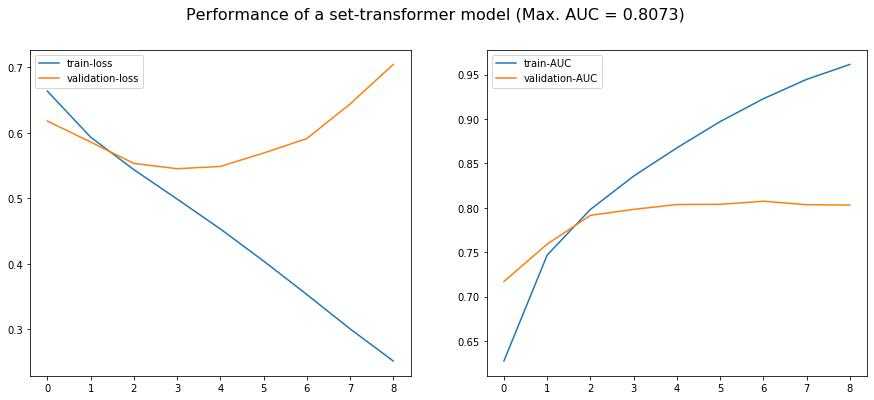

In [17]:
auc_str = "auc_1"
f, axs = plt.subplots(1,2,figsize=(15,6))
max_val_auc = max(history.history[f'val_{auc_str}'])
f.suptitle(f'Performance of a {model_type} model (Max. AUC = {max_val_auc:.4})', fontsize=16)
plt.subplot(121)
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='validation-loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history[auc_str], label='train-AUC')
plt.plot(history.history[f'val_{auc_str}'], label='validation-AUC')
plt.legend()

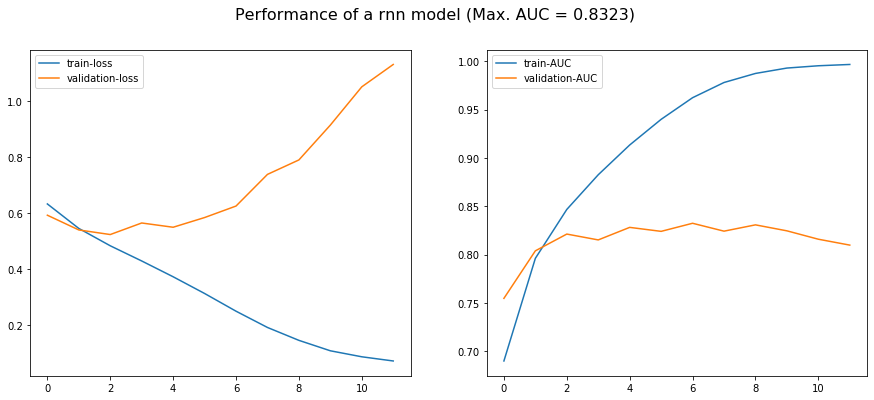

In [16]:
auc_str = "auc"
f, axs = plt.subplots(1,2,figsize=(15,6))
max_val_auc = max(history.history[f'val_{auc_str}'])
f.suptitle(f'Performance of a {model_type} model (Max. AUC = {max_val_auc:.4})', fontsize=16)
plt.subplot(121)
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='validation-loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history[auc_str], label='train-AUC')
plt.plot(history.history[f'val_{auc_str}'], label='validation-AUC')
plt.legend()

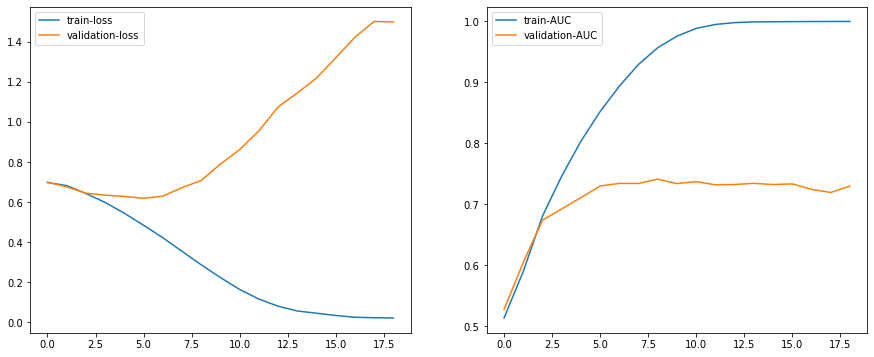

In [54]:
f, axs = plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='validation-loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['auc_9'], label='train-AUC')
plt.plot(history.history['val_auc_9'], label='validation-AUC')
plt.legend()

In [14]:
test_gen = CustomDataGen(test_X, test_y, 
                          item_dict, 
                          pv_items, 
                          image_dir, 
                          batch_size=batch_size, 
                          only_image=not include_text,
                          image_embedding=True,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file=image_embedding_file,
                          text_embedding_file="bert_polyvore.pkl",)

In [33]:
def get_accuracy_auc(data_gen):
    m = tf.keras.metrics.BinaryAccuracy()
    m2 = tf.keras.metrics.AUC()
    acc_list = []
    pbar = tqdm(range(len(data_gen)))
    ys, yhats = [], []
    for ii in pbar:
        x, y = data_gen[ii]  # batch size
        yhat = model(x)
        m.update_state(y, yhat)
        batch_acc = m.result().numpy()
        acc_list.append(batch_acc)
        pbar.set_description("Batch accuracy %g" % batch_acc)
        ys.append(y)
        yhats.append(yhat)
    print(f"Average Accuracy: {np.mean(acc_list)}")
    big_y = np.concatenate(ys, axis=0)
    big_yh = np.concatenate(yhats, axis=0)
    m2.update_state(big_y, big_yh)
    auc = m2.result().numpy()
    print(f"AUC: {auc}")


In [35]:
get_accuracy_auc(train_gen)

Batch accuracy 0.919822: 100%|██████████| 1063/1063 [00:32<00:00, 32.94it/s]


Average Accuracy: 0.9177117347717285
AUC: 0.9803071618080139


In [36]:
get_accuracy_auc(valid_gen)

Batch accuracy 0.691323: 100%|██████████| 188/188 [00:05<00:00, 32.20it/s]


Average Accuracy: 0.6867008805274963
AUC: 0.7629901766777039


In [34]:
get_accuracy_auc(test_gen)

Batch accuracy 0.674806: 100%|██████████| 947/947 [00:28<00:00, 33.24it/s]


Average Accuracy: 0.6465033292770386
AUC: 0.7359540462493896


## Text Embeddings

 - pre-compute all the text embeddings

In [13]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state
# pooled_output = outputs.pooler_output.detach().numpy()
# pooled_output[0,:].shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
def get_texts(item_id, item_description):
    item = item_description[item_id]  # item attributes
    text = " ".join(
        [
            item["url_name"],
            item["description"],
            item["title"],
            item["semantic_category"],
        ]
    )
#     text = " ".join(text.split()[:512])
    return text

bert_dict = {}
for item_id in tqdm(pv_items):
    text = get_texts(item_id, pv_items)
    inputs = tokenizer(text, return_tensors="pt")
    new_inputs = {'input_ids': inputs['input_ids'][:,:512], 
                  'token_type_ids': inputs['token_type_ids'][:,:512], 
                  'attention_mask': inputs['attention_mask'][:,:512]}
    outputs = model(**new_inputs)
#     outputs = model(input_ids=inputs['input_ids'][:,:512], 
#           attention_mask=inputs['attention_mask'][:,:512], 
#           token_type_ids=inputs['token_type_ids'][:,:512])
    text_emb = outputs.pooler_output.detach().numpy()[0, :]
    bert_dict[item_id] = text_emb
    

100%|██████████| 251008/251008 [4:44:18<00:00, 14.71it/s]  


In [32]:
with open("bert_polyvore.pkl", "wb") as output_file:
    pickle.dump(bert_dict, output_file)

## Image Embeddings

In [ ]:
import glob
efficient_net_dict = {}

eff2_model = tf.keras.models.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
                    effnetv2_model.get_model("efficientnetv2-b0", include_top=False),
                ]
            )

for image_path in tqdm(glob.glob(image_dir+"/*.jpg")):
    item_id = image_path.split('/')[-1].split('.')[0]
    image = tf.keras.preprocessing.image.load_img(image_path)
    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    image_arr = tf.image.resize(image_arr, (224, 224)).numpy()
    image_arr /= 255.0
    image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
    efficient_net_dict[item_id] = image_embed

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.
 70%|███████   | 183608/261057 [5:51:32<2:25:03,  8.90it/s]

In [8]:
with open("effnet2_polyvore.pkl", "wb") as output_file:
    pickle.dump(efficient_net_dict, output_file)

In [2]:
class image_embedding_layer(tf.keras.layers.Layer):
    def __init__(self, dropout, embedding_dim, activation):
        super(image_embedding_layer, self).__init__()
        self.dropout = dropout
        self.embedding_dim = embedding_dim
        self.activation = activation

    def build(self, input_shape):
        self.layer = tf.keras.Sequential(
            [
                effnetv2_model.get_model("efficientnetv2-b0", include_top=False),
                tf.keras.layers.Dropout(rate=self.dropout),
                tf.keras.layers.Dense(self.embedding_dim, activation=self.activation),
            ]
        )

    def call(self, input_tensor):
        return self.layer(input_tensor)


In [ ]:
inputs = tf.keras.layers.Input(shape=[224, 224, 3])
output = image_embedding_layer(0.1, 256, "tanh")(inputs)
model = tensorflow.keras.models.Model(inputs=inputs, outputs=output)
model.summary()

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
    effnetv2_model.get_model('efficientnetv2-b0', include_top=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])

In [ ]:
im_layer = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
    effnetv2_model.get_model('efficientnetv2-b0', include_top=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])

In [ ]:
inputs = tf.keras.Input(shape=(16, 224, 224, 3))
outputs = tf.keras.layers.TimeDistributed(model)(inputs)
outputs.shape

In [10]:
MODEL = 'efficientnetv2-b0'  #@param

def download(m):
    if m not in os.listdir():
        !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{m}.tgz
        !tar zxf {m}.tgz
    ckpt_path = os.path.join(os.getcwd(), m)
    return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
if tf.io.gfile.isdir(ckpt_path):
    ckpt_path = tf.train.latest_checkpoint(ckpt_path)

--2022-07-09 07:51:48--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-b0.tgz
Resolving storage.googleapis.com... 142.250.138.128, 142.251.45.48, 142.251.35.208, ...
Connecting to storage.googleapis.com|142.250.138.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105641132 (101M) [application/octet-stream]
Saving to: ‘efficientnetv2-b0.tgz’

efficientnetv2-b0.t 100%[===================>] 100.75M  43.7MB/s    in 2.3s    

2022-07-09 07:51:50 (43.7 MB/s) - ‘efficientnetv2-b0.tgz’ saved [105641132/105641132]



In [25]:
resnet152 = tf.keras.applications.resnet.ResNet152(
    include_top=False,
    weights='imagenet',
    pooling='avg',
)
in1 = tf.keras.layers.Input(shape=(8, 224, 224, 3))
out = tf.keras.layers.TimeDistributed(resnet152)(in1)
test_model = tf.keras.models.Model(inputs=in1, outputs=out, name="test")
test_model.summary()

Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 8, 224, 224, 3)]  0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 8, 2048)           58370944  
Total params: 58,370,944
Trainable params: 58,219,520
Non-trainable params: 151,424
_________________________________________________________________
